In [ ]:
# https://www.kaggle.com/code/kashnitsky/topic-9-part-1-time-series-analysis-in-python/notebook

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
from dateutil.relativedelta import relativedelta #working wd dates style
from scipy.optimize import minimize #for func minimization

import statsmodels.formula.api as smf #statistics n economertics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


In [ ]:
from itertools import product #some useful functions
from tqdm import tqdm_notebook

%matplotlib inline

In [ ]:
ads = pd.read_csv('/content/ads.csv',index_col=['Time'], parse_dates=['Time'])
currency = pd.read_csv('/content/currency.csv',index_col=['Time'], parse_dates=['Time'])

In [ ]:
ads.head(5)

,Ads
Time,
2017-09-13 00:00:00,80115
2017-09-13 01:00:00,79885
2017-09-13 02:00:00,89325
2017-09-13 03:00:00,101930
2017-09-13 04:00:00,121630


In [ ]:
currency.head(5)

,GEMS_GEMS_SPENT
Time,
2017-05-01,1199436
2017-05-02,1045515
2017-05-03,586111
2017-05-04,856601
2017-05-05,793775


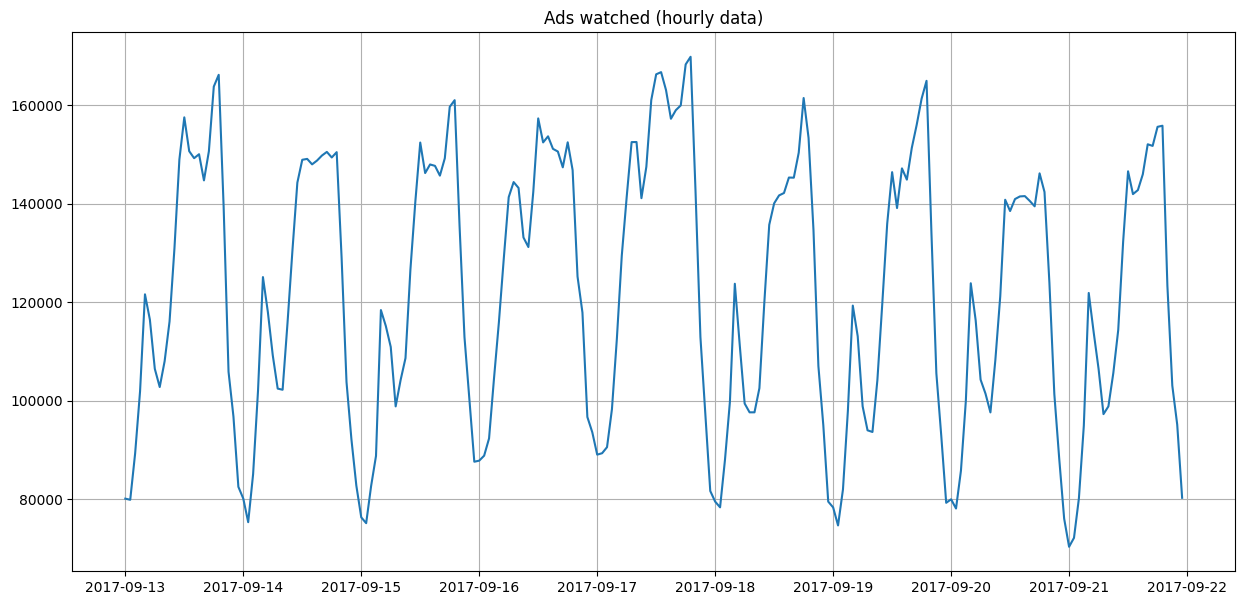

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(ads.Ads)
plt.title('Ads watched (hourly data)')
plt.grid(True)
plt.show()

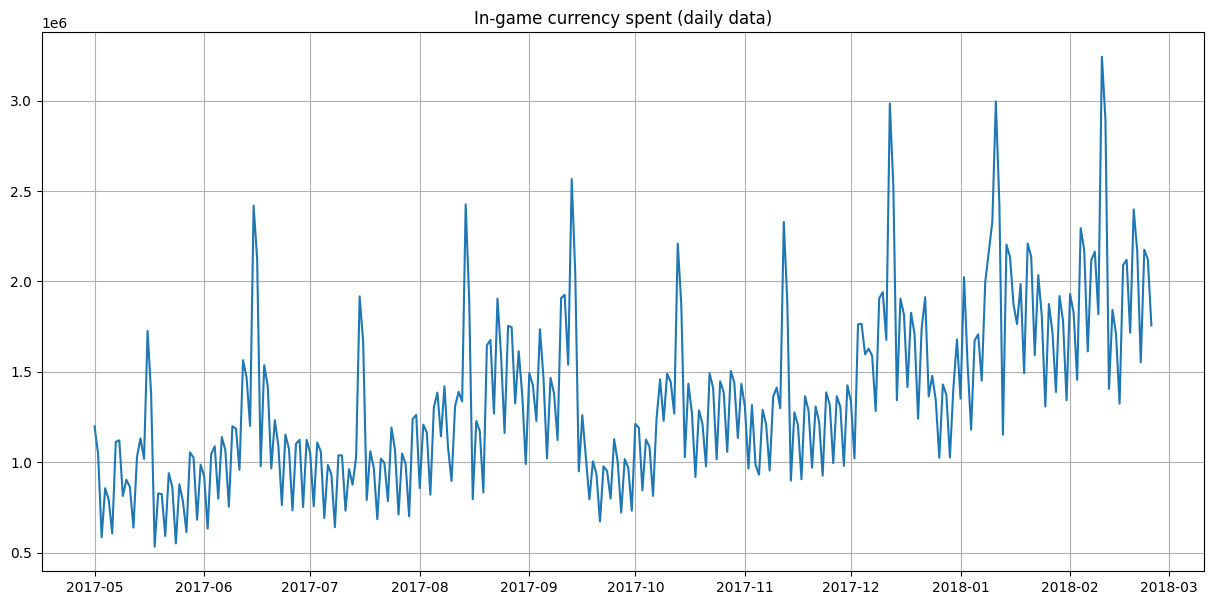

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(currency.GEMS_GEMS_SPENT)
plt.title('In-game currency spent (daily data)')
plt.grid(True)
plt.show()

In [ ]:
# Forecast quality metrics¶



# Before we begin forecasting, let's understand how to measure the quality of our predictions and take a look at the most commonly used metrics.

# R squared: coefficient of determination (in econometrics, this can be interpreted as the percentage of variance explained by the model)

In [ ]:
# sklearn.metrics.r2_score

In [ ]:
# Mean Absolute Error: this is an interpretable metric because it has the same unit of measurment as the initial series,  [0,+∞)

In [ ]:
# sklearn.metrics.mean_absolute_error

In [ ]:
# Median Absolute Error: again, an interpretable metric that is particularly interesting because it is robust to outliers

In [ ]:
# sklearn.metrics.median_absolute_error

In [ ]:
# Mean Squared Error: the most commonly used metric that gives a higher penalty to large errors and vice versa

In [ ]:
# sklearn.metrics.mean_squared_erro

In [ ]:
# Mean Squared Logarithmic Error: practically, this is the same as MSE, but we take the logarithm of the series. As a result, we give more weight to small mistakes as well. This is usually used when the data has exponential trends

In [ ]:
# sklearn.metrics.mean_squared_log_error

In [ ]:
# Mean Absolute Percentage Error: this is the same as MAE but is computed as a percentage, which is very convenient when you want to explain the quality of the model to management

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
# Importing everything from above

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
# Move, smoothe, evaluate

In [ ]:
# we will assume that the future value of our variable depends on the average of its  k
#   previous values. Therefore, we will use the moving averag

In [ ]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

moving_average(ads, 24) # prediction for the last observed day (past 24 hours)


116805.0

In [ ]:
# Unfortunately, we cannot make predictions far in the future -- in order to get the value for the next step, we need the previous values to be actually observed. But moving average has another use case - smoothing the original time series to identify trends. Pandas has an implementation available with DataFrame.rolling(window).mean(). The wider the window, the smoother the trend. In the case of very noisy data, which is often encountered in finance, this procedure can help detect common patterns

In [ ]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")
    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")

        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)

    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)


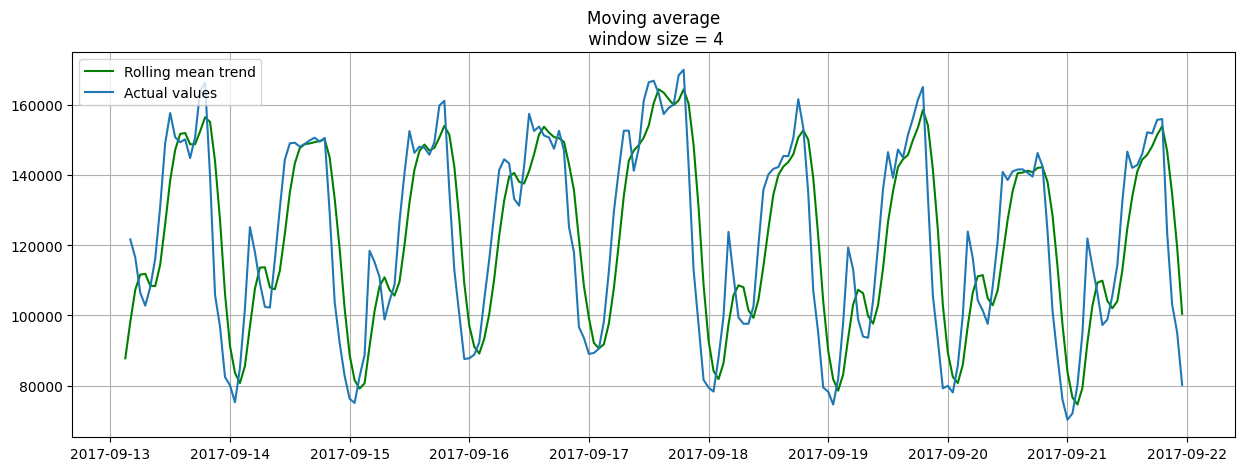

In [ ]:
plotMovingAverage(ads, 4)

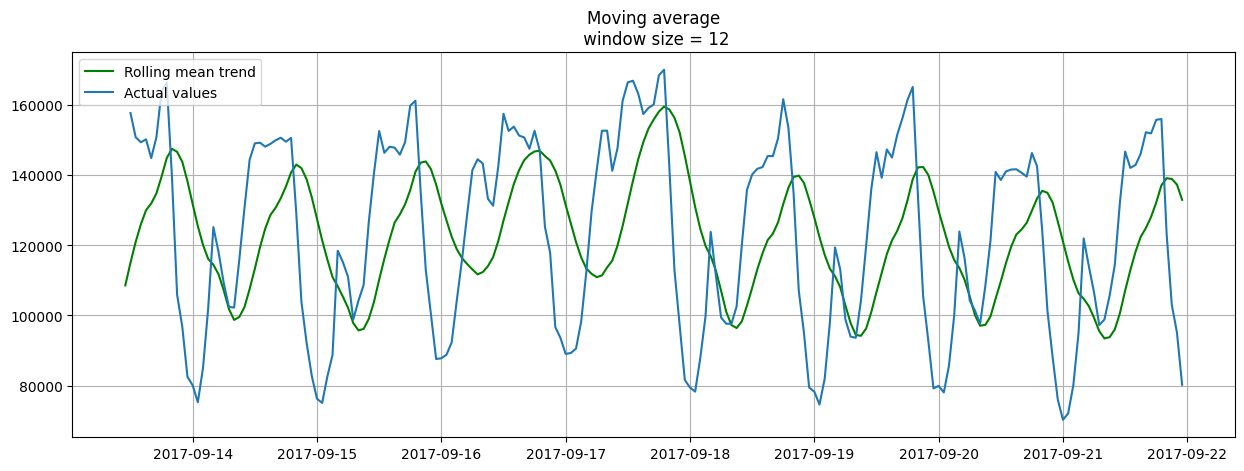

In [ ]:
# Now let's try smoothing by the previous 12 hours

plotMovingAverage(ads, 12)

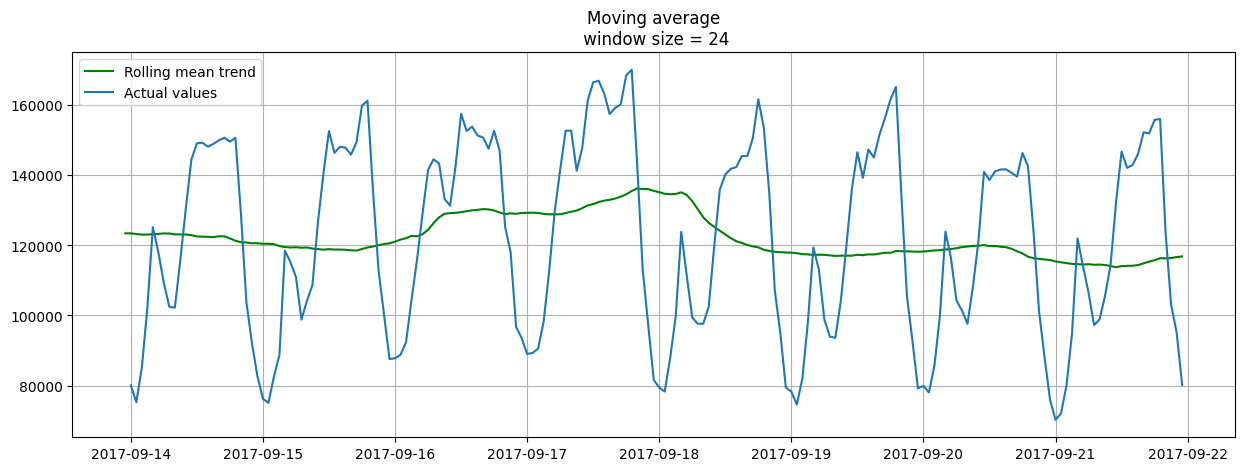

In [ ]:
plotMovingAverage(ads, 24)

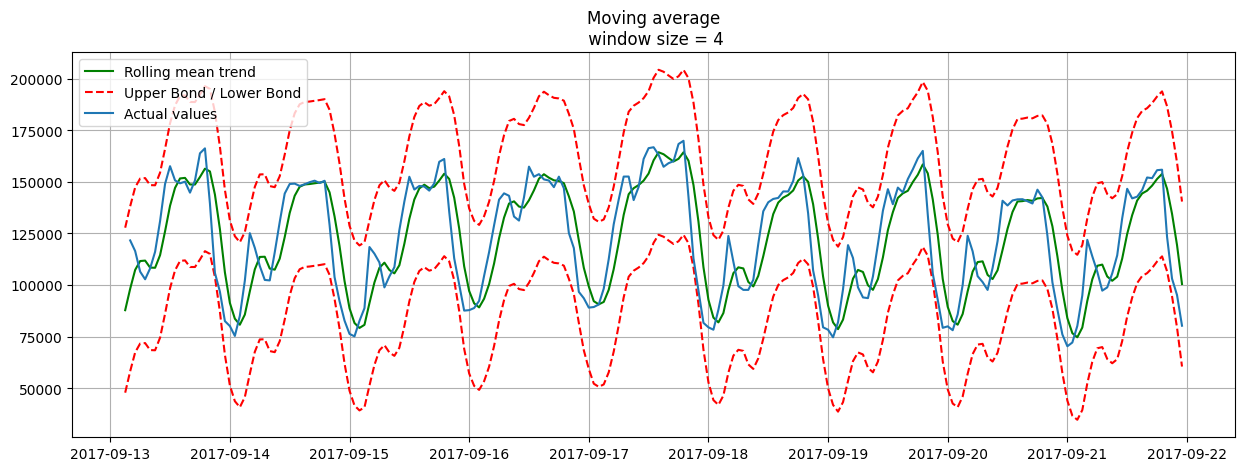

In [ ]:
# We can also plot confidence intervals for our smoothed values.



plotMovingAverage(ads, 4, plot_intervals=True)

In [ ]:
# Now, let's create a simple anomaly detection system with the help of moving average. Unfortunately, in this particular dataset, everything is more or less normal, so we will intentionally make one of the values abnormal in our dataframe ads_anomaly

In [ ]:
ads_anomaly = ads.copy()
ads_anomaly.iloc[-20] = ads_anomaly.iloc[-20] * 0.2 # say we have 80% drop of ads

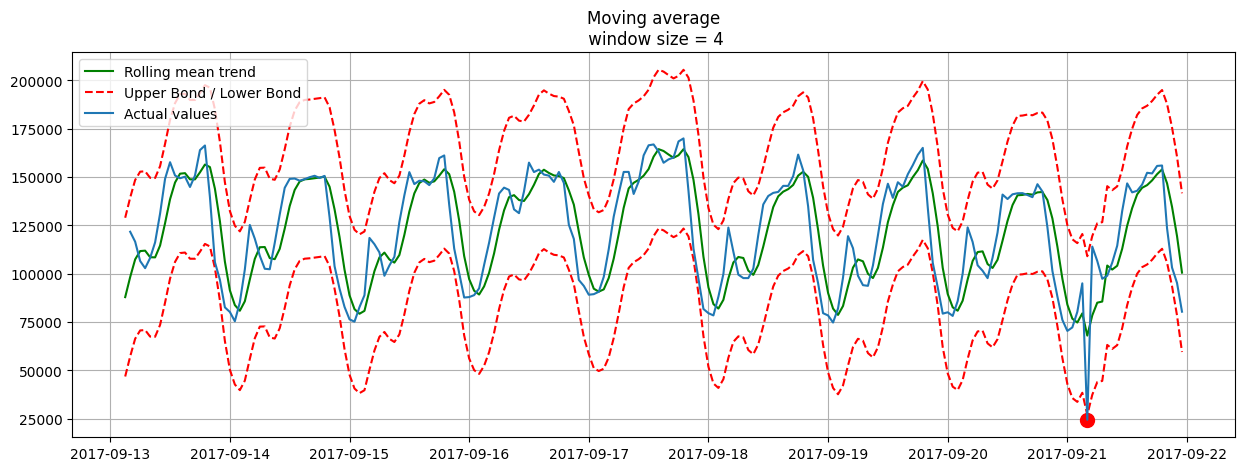

In [ ]:
plotMovingAverage(ads_anomaly, 4, plot_intervals=True, plot_anomalies=True)

In [ ]:
# Neat! What about the second series?

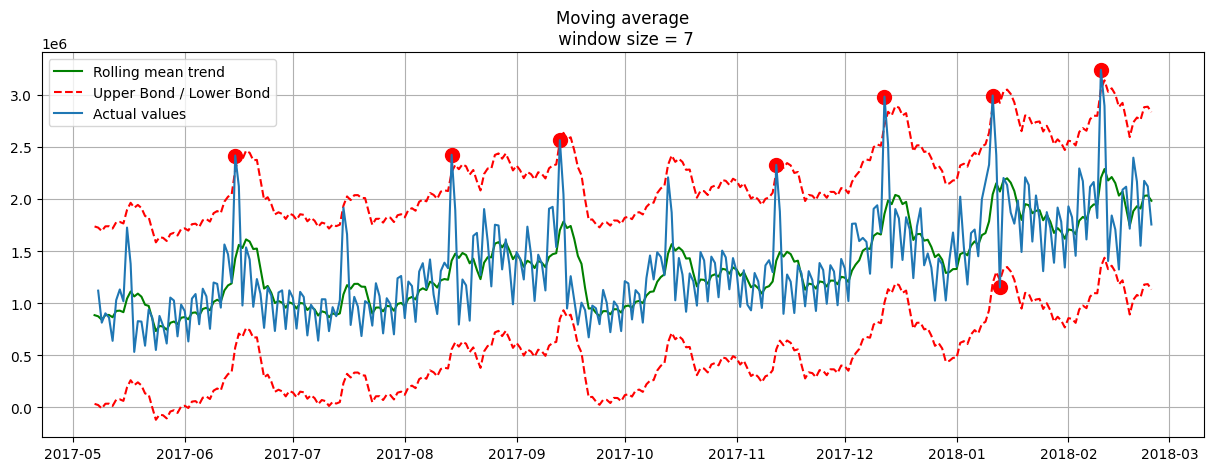

In [ ]:
plotMovingAverage(currency, 7, plot_intervals=True, plot_anomalies=True) # weekly smoothing

In [ ]:
# Important

In [ ]:
# Oh no, this was not as great! Here, we can see the downside of our simple approach -- it did not capture the monthly seasonality in our data and marked almost all 30-day peaks as anomalies. If you want to avoid false positives, it is best to consider more complex models.

# Weighted average is a simple modification to the moving average. The weights sum up to 1 with larger weights assigned to more recent observations.

In [ ]:
def weighted_average(series, weights):
    """
        Calculate weighted average on the series.
        Assuming weights are sorted in descending order
        (larger weights are assigned to more recent observations).
    """
    result = 0.0
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return float(result)

In [ ]:
weighted_average(ads, [0.6, 0.3, 0.1])

87025.5

In [ ]:
# Exponential smoothing

In [ ]:
# Now, let's see what happens if, instead of weighting the last  k
  # values of the time series, we start weighting all available observations while exponentially decreasing the weights as we move further back in time. There exists a formula for exponential smoothing that will help us with this:

In [ ]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [ ]:
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas

        series - dataset with timestamps
        alphas - list of floats, smoothing parameters

    """
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);


In [ ]:
plotExponentialSmoothing(ads.Ads, [0.3, 0.05])

OSError: 'seaborn-white' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

In [ ]:
plotExponentialSmoothing(currency.GEMS_GEMS_SPENT, [0.3, 0.05])

OSError: 'seaborn-white' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

In [ ]:
# Double exponential smoothing

In [ ]:
# Up to now, the methods that we've discussed have been for a single future point prediction (with some nice smoothing). That is cool, but it is also not enough. Let's extend exponential smoothing so that we can predict two future points (of course, we will also include more smoothing).

In [ ]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas

        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

In [ ]:
plotDoubleExponentialSmoothing(ads.Ads, alphas=[0.9, 0.02], betas=[0.9, 0.02])

OSError: 'seaborn-white' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

In [ ]:
plotDoubleExponentialSmoothing(currency.GEMS_GEMS_SPENT, alphas=[0.9, 0.02], betas=[0.9, 0.02])

OSError: 'seaborn-white' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

In [ ]:
# Triple exponential smoothing a.k.a. Holt-Winters¶

In [ ]:
# We've looked at exponential smoothing and double exponential smoothing. This time, we're going into triple exponential smoothing